In [30]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from sklearn.metrics import classification_report

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, BatchNormalization, Flatten, Dense, Dropout, Activation

from skimage import io, transform, exposure

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from mpl_toolkits.axes_grid1 import ImageGrid

import pandas as pd
import numpy as np

from datetime import datetime
import random
import os

# Load CSVs Tran and Test

In [2]:
df_Train = pd.read_csv("../dataset/archive/Train.csv")[["ClassId", "Path"]]
df_Test = pd.read_csv("../dataset/archive/Test.csv")[["ClassId", "Path"]]

In [3]:
df_Train

,ClassId,Path
0,20,Train/20/00020_00000_00000.png
1,20,Train/20/00020_00000_00001.png
2,20,Train/20/00020_00000_00002.png
3,20,Train/20/00020_00000_00003.png
4,20,Train/20/00020_00000_00004.png
...,...,...
39204,42,Train/42/00042_00007_00025.png
39205,42,Train/42/00042_00007_00026.png
39206,42,Train/42/00042_00007_00027.png
39207,42,Train/42/00042_00007_00028.png


In [4]:
total = df_Train.shape[0]+df_Test.shape[0]
print(f"Train Size: {df_Train.shape[0]} images ({df_Train.shape[0]/ total*100})")
print(f"Test Size: {df_Test.shape[0]} images ({df_Test.shape[0]/ total*100})")

Train Size: 39209 images (75.63610409151411)
Test Size: 12630 images (24.363895908485887)


In [46]:
im_list = []
for i in range(0, 16):
    id = random.randint(0, df_Train.shape[0])
    image = mpimg.imread(f'../dataset/archive/{df_Train["Path"][id]}')
    image = transform.resize(image, (64,64))
    im_list.append(image)

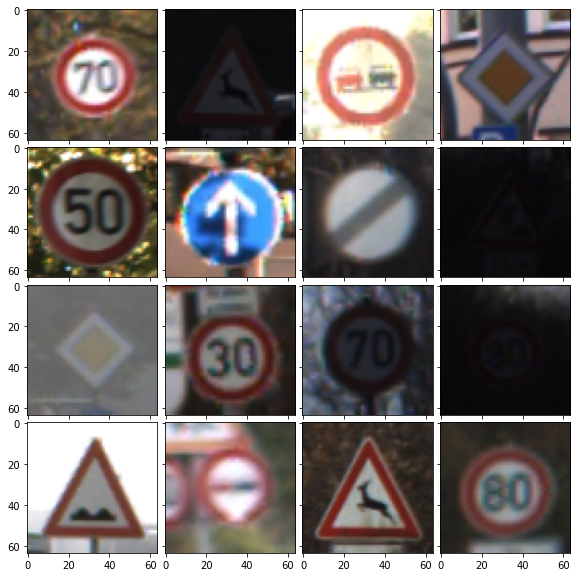

In [47]:
fig = plt.figure(figsize=(10, 10))
grid = ImageGrid(fig, 111,  
                 nrows_ncols=(4, 4), 
                 axes_pad=0.1,  # pad between axes in inch.
                 )


for ax, im in zip(grid, im_list):
    # Iterating over the grid returns the Axes.
    ax.imshow(im)

39209

In [ ]:
f, axarr = plt.subplots(2,2)
axarr[0,0].imshow(image_datas[0])
axarr[0,1].imshow(image_datas[1])
axarr[1,0].imshow(image_datas[2])
axarr[1,1].imshow(image_datas[3])

# Function to Load Images 

In [8]:
# This function first shuffle the dataset, after load the image to memory, resize it, equelize the contrast and finally save to an array.
def load_images(main_path, df):
    data = []
    
    # SHUFFLE DATA FRAME
    df_shuffle = df.sample(frac=1)
    
    for (i, image_path) in enumerate(df):
        if i > 0 and i % 1000 == 0:
            print(f"[DEBUG] Total processed images: {i}")
            
        image_full_path = os.path.sep.join([main_path, image_path])
        image = io.imread(image_full_path)

        image = transform.resize(image, (32,32))
        image = exposure.equalize_adapthist(image, clip_limit=0.1)

        data.append(image)
            
    data = np.array(data)
    return data

# Model Function

In [9]:
def build(width, height, depth, classes, conv_size, dense_size, filter_size):
        model = Sequential()

        inputShape = (height, width, depth)
        dim = 1

        model.add(Conv2D(filter_size[0], conv_size[0], padding = "same", input_shape = inputShape))
        model.add(Activation("relu"))
        model.add(BatchNormalization(axis=dim))
        model.add(MaxPooling2D(pool_size=(2,2)))

        model.add(Conv2D(filter_size[1], conv_size[1], padding="same"))
        model.add(Activation("relu"))
        model.add(BatchNormalization(axis=dim))
        model.add(Conv2D(filter_size[1], conv_size[1], padding = "same"))
        model.add(Activation("relu"))
        model.add(BatchNormalization(axis=dim))
        model.add(MaxPooling2D(pool_size=(2,2)))

        model.add(Conv2D(filter_size[2], conv_size[2], padding="same"))
        model.add(Activation("relu"))
        model.add(BatchNormalization(axis=dim))
        model.add(Conv2D(filter_size[2], conv_size[2], padding = "same"))
        model.add(Activation("relu"))
        model.add(BatchNormalization(axis=dim))
        model.add(MaxPooling2D(pool_size=(2,2)))

        model.add(Flatten())
        model.add(Dense(dense_size[0]))
        model.add(Activation("relu"))
        model.add(BatchNormalization())
        model.add(Dropout(0.5))

        model.add(Flatten())
        model.add(Dense(dense_size[1]))
        model.add(Activation("relu"))
        model.add(BatchNormalization())
        model.add(Dropout(0.5))

        model.add(Dense(classes))
        model.add(Activation("softmax"))

        return model

In [14]:
def saveModel(model, path):
    # GETTING THE CURRENT TIME
    now = datetime.now()
    date = now.strftime("%d_%m_%Y_%H_%M_%S")
    
    # SAVING MODEL
    model_path = path + date
    print(f"[INFO] serialiazing network to {model_path}")
    model.save(model_path)

In [53]:
def printPrediction(model, Y_Test, prediction, label_names, file_name):
    pred = classification_report(Y_Test.argmax(axis=1), prediction.argmax(axis=1), target_names = label_names, output_dict=True)
#     print(pred)
    
    df_pred = pd.DataFrame(pred).transpose()
    df_pred.to_csv(file_name)


In [58]:
def savePlotMetrics(num_epochs, hist, path, title):
    N = np.arange(0, num_epochs)
    plt.style.use("ggplot")
    plt.figure()
    plt.plot(N, hist.history["loss"], label="train_loss")
    plt.plot(N, hist.history["val_loss"], label="val_loss")
    plt.plot(N, hist.history["accuracy"], label="train_acc")
    plt.plot(N, hist.history["val_accuracy"], label="val_acc")
    plt.title(f"Training Loss and Accuracy on Database - {title}.")
    plt.xlabel("Epoch")
    plt.ylabel("Loss/Accuracy")
    plt.legend()
    plt.savefig(path)

In [75]:
def saveHist(hist, file_name):
    df_hist = pd.DataFrame(hist.history)
    df_hist.to_csv(file_name)

In [ ]:
def run():
    NUM_EPOCHS = 30
    INIT_LR = 0.001
    BS = 64

    print(f"[DEBUG] Loading dataset ...\n")
    df_Train = pd.read_csv("../dataset/archive/Train.csv")[["ClassId", "Path"]]
    df_Test = pd.read_csv("../dataset/archive/Test.csv")[["ClassId", "Path"]]
    label_names = pd.read_csv("../dataset/archive/signnames.csv")["SignName"]

    print(f"[DEBUG] Load images from file and prepare data ...\n")
    X_Train = load_images("../dataset/archive", df_Train["Path"])
    X_Test = load_images("../dataset/archive", df_Test["Path"])

    # GET THE TOTAL UNIQUE TRANSIT SIGN
    num_labels = df_Train["ClassId"].unique().size

    # GET THE Y CLASS
    Y_Train = np.array(df_Train["ClassId"])
    Y_Test = np.array(df_Test["ClassId"])

    # NORMALIZE THE RGB PIXELS VALUES
    X_Train = X_Train.astype("float32") / 255.0
    X_Test  = X_Test.astype("float32") / 255.0

    # ONE HOT ENCODING
    Y_Train = to_categorical(Y_Train, num_labels)
    Y_Test = to_categorical(Y_Test, num_labels)  

    # CREATE A DICTIONARY BY CLASS AND CALC THE WEIGHT, THIS BECAUSE THE DATASET IS NOT HOMOGENEOUS
    # GET THE TOTAL TRANSIT SIGN IMAGES
    total_classes = Y_Train.sum(axis=0)
    class_weight = dict()

    # CALCULATE THE CLASS WEIGHT
    for i in range(0, len(total_classes)):
        class_weight[i] = total_classes.max() / total_classes[i]


    conv_size   = [[(2,2), (3,3), (3,3)], [(3,3), (3,3), (3,3)] , [(5,5), (3,3), (3,3)], [(5,5), (5,5), (5,5)], [(5,5), (8,8), (4,4)]]
    dense_size  = [[64, 64], [64, 128], [128, 256], [256, 256], [256, 512]]
    filter_size = [[4,4,8], [4,8,16], [8,16,32], [16,32,64], [32,32,64]]

    for i in range(0, len(conv_size)):
        # IMAGE GENERATOR
        img_gen = ImageDataGenerator(rotation_range = 10,
                                     zoom_range = 0.15,
                                     width_shift_range = 0.1,
                                     height_shift_range = 0.1,
                                     shear_range = 0.15,
                                     horizontal_flip = False,
                                     vertical_flip = False,
                                     fill_mode = "nearest")

        print(f"[DEBUG] Config Model ...\n")
        # ADAM OPTIMIZER
        opt = Adam(learning_rate=INIT_LR, decay = INIT_LR / (NUM_EPOCHS * 0.5))                

        # CNN
        model = build(width = 32, height = 32, depth = 3, classes = num_labels, conv_size = conv_size[i], dense_size = dense_size[i], filter_size = filter_size[i])
        model.compile(loss = "categorical_crossentropy", optimizer = opt, metrics = ["accuracy"])

        print(f"[DEBUG] Training ...\n")

        hist = model.fit(img_gen.flow(X_Train, Y_Train, batch_size = BS),
                        validation_data = (X_Test, Y_Test), 
                        steps_per_epoch = X_Train.shape[0] // BS,
                        epochs = NUM_EPOCHS,
                        class_weight = class_weight,
                        verbose = 1)

        print(f"[DEBUG] Evaluating ...\n")
        prediction = model.predict(X_Test, batch_size = BS)

        conv_name = f"_Conv_{conv_size[i][0][0]}x{conv_size[i][0][1]}_{conv_size[i][1][0]}x{conv_size[i][1][1]}_{conv_size[i][2][0]}x{conv_size[i][2][1]}"
        dense_name = f"_Dense_{dense_size[i][0]}_{dense_size[i][1]}"
        filter_name = f"_Filter_{filter_size[i][0]}_{filter_size[i][1]}_{filter_size[i][2]}"

        model_name = conv_name+dense_name+filter_name

        print(f"[DEBUG] Saving Prediction ...\n")
        printPrediction(model, Y_Test, prediction, label_names, f"../plots/pred_{model_name}.csv")
        print(f"[DEBUG] Saving Model ...\n")
        saveModel(model, f"../models/sign_model_{model_name}.h5")
        print(f"[DEBUG] Saving plot ...\n")        
        savePlotMetrics(NUM_EPOCHS, hist, f"../plots/plot_{model_name}.png", model_name)
        print(f"[DEBUG] Saving hist ...\n")          
        saveHist(hist,f"../hists/hist_{model_name}.csv")

    
    

In [63]:
# run()